In [2]:
import warnings

# Ignore all warnings
warnings.simplefilter("ignore")

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary

plt.ion() 

## Data Processing 

In [3]:
data_dir = "./"
i_dir = "images"
a_dir = "annotation.csv"

df_train = pd.read_csv(os.path.join(data_dir, a_dir))


n_train = df_train['img_name'].size

df_kp = df_train.iloc[:,0:28]

idxs = []

img_dict = {}
kp_dict = {}

for i in range(n_train):
    
    # only select data from csv that has 14 keypoint labels
    if True in df_train.iloc[i, 0:30].isna().values:
        continue
    else:
        idxs.append(i)
        img_dict[i] = "images"+str(i)+".jpg"
        kp = df_kp.iloc[i].values.tolist()
        kp_dict[i] = kp

In [4]:
print(n_train, len(idxs))

10000 10000


In [5]:
landmarks_frame = pd.read_csv(a_dir)

n = 100
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

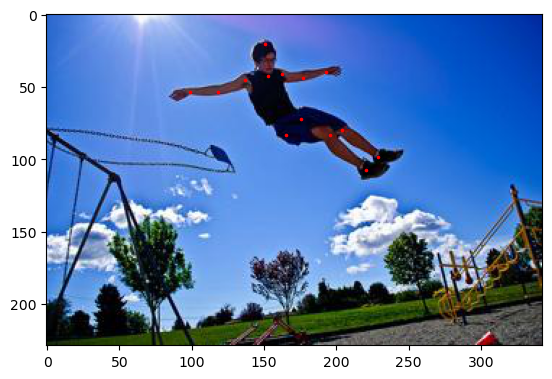

In [6]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join(i_dir, img_name)),
               landmarks)
plt.show()

In [7]:
class PoseLandmarksDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (105, 157, 3) (14, 2)


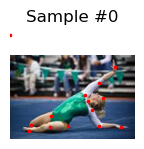

In [8]:
pose_dataset = PoseLandmarksDataset(csv_file= a_dir,
                                    root_dir= i_dir)

fig = plt.figure()

for i, sample in enumerate(pose_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 0:
        plt.show()
        break

In [9]:
class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        landmarks = np.array(landmarks, dtype=np.float32)/ image.shape[0]
        landmarks = landmarks.flatten()
        image = image.transpose((2, 0, 1))
        return {'image': np.array(image, dtype=np.float32),
                'landmarks': landmarks}

0 150528 [-0.0625     -0.24865822  0.1847229   0.82295454  0.41813698  0.72096
  0.61873645  0.83397293  0.4044766   0.84767145  0.1572537   0.90276337
  1.1846021   0.13147618  0.9978116   0.3298072   0.8275024   0.46753702
  0.9099101   0.6520206   0.98964506  0.84216225  1.2588433   0.8531806
  0.8576444   0.53915656  1.0445834   0.50878155]
236544


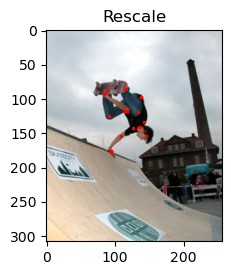

49152


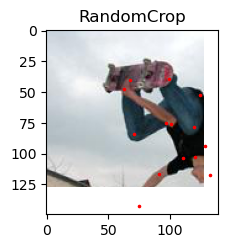

150528


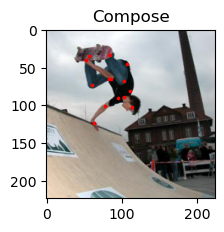

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
transformed_dataset = PoseLandmarksDataset(csv_file= a_dir,
                                           root_dir= i_dir,
                                           transform=transforms.Compose([
                                               Rescale(224),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size, sample['landmarks']) 

    if i == 0:
        break
        
fig = plt.figure()
sample = pose_dataset[60]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    print(transformed_sample['image'].size)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Data Splitting

In [25]:
train_size = int(0.7 * len(transformed_dataset))
val_size = int(0.15 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(transformed_dataset, [train_size, val_size, test_size], generator= torch.Generator().manual_seed(42))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,  batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

print(len(train_loader), len(val_loader), len(test_loader))


110 24 24


In [26]:
sample = next(iter(train_loader))

print(sample["image"][0], sample["landmarks"][0])

tensor([[[0.0580, 0.0578, 0.0575,  ..., 0.5085, 0.5065, 0.5059],
         [0.0595, 0.0595, 0.0595,  ..., 0.5093, 0.5059, 0.5048],
         [0.0708, 0.0708, 0.0708,  ..., 0.5148, 0.5102, 0.5087],
         ...,
         [0.3851, 0.3851, 0.3851,  ..., 0.4196, 0.4196, 0.4196],
         [0.3968, 0.3968, 0.3968,  ..., 0.4196, 0.4196, 0.4196],
         [0.4021, 0.4021, 0.4021,  ..., 0.4252, 0.4257, 0.4259]],

        [[0.0750, 0.0748, 0.0744,  ..., 0.2399, 0.2379, 0.2373],
         [0.0752, 0.0752, 0.0752,  ..., 0.2363, 0.2330, 0.2319],
         [0.0863, 0.0863, 0.0863,  ..., 0.2269, 0.2223, 0.2208],
         ...,
         [0.3890, 0.3890, 0.3890,  ..., 0.4235, 0.4235, 0.4235],
         [0.4008, 0.4008, 0.4008,  ..., 0.4235, 0.4235, 0.4235],
         [0.4060, 0.4060, 0.4060,  ..., 0.4291, 0.4297, 0.4298]],

        [[0.1135, 0.1134, 0.1130,  ..., 0.2104, 0.2085, 0.2078],
         [0.1003, 0.1003, 0.1003,  ..., 0.2044, 0.2011, 0.2000],
         [0.0975, 0.0975, 0.0975,  ..., 0.2005, 0.1958, 0.

## Model Architecture

In [27]:
class CNN(nn.Module):
    def __init__(self, num_classes=28):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 512),
            nn.ReLU())
        self.fc1= nn.Sequential(
            nn.Linear(512, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        return out

model = CNN().cuda()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

## Training & Validation

In [28]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.MSELoss()

In [29]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"epoch: {epoch_index}"):
        inputs, labels = data['image'], data['landmarks']
        inputs, labels  = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    last_loss = running_loss / len(train_loader)
    print('  batch {} loss: {}'.format(i + 1, last_loss))
    tb_x = epoch_index * len(train_loader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.

    return last_loss

In [30]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/human_pose_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 200

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata['image'], vdata["landmarks"]
            vinputs, vlabels = vinputs.cuda(), vlabels.cuda()
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


epoch: 0: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [23:24<00:00, 12.77s/it]


  batch 110 loss: 0.12636510181156071
LOSS train 0.12636510181156071 valid 0.10003028810024261
EPOCH 2:


epoch: 1: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:32<00:00, 12.30s/it]


  batch 110 loss: 0.10048060857436873
LOSS train 0.10048060857436873 valid 0.09778481721878052
EPOCH 3:


epoch: 2: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:34<00:00, 12.32s/it]


  batch 110 loss: 0.09897629571231929
LOSS train 0.09897629571231929 valid 0.0959077924489975
EPOCH 4:


epoch: 3: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:58<00:00, 12.53s/it]


  batch 110 loss: 0.0974152111871676
LOSS train 0.0974152111871676 valid 0.09694831818342209
EPOCH 5:


epoch: 4: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:32<00:00, 12.30s/it]


  batch 110 loss: 0.09597966223955154
LOSS train 0.09597966223955154 valid 0.09443195909261703
EPOCH 6:


epoch: 5: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:27<00:00, 12.25s/it]


  batch 110 loss: 0.0951633942398158
LOSS train 0.0951633942398158 valid 0.09337019175291061
EPOCH 7:


epoch: 6: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:28<00:00, 12.26s/it]


  batch 110 loss: 0.09410872371359305
LOSS train 0.09410872371359305 valid 0.09133964776992798
EPOCH 8:


epoch: 7: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:28<00:00, 12.26s/it]


  batch 110 loss: 0.09363358190113848
LOSS train 0.09363358190113848 valid 0.09371339529752731
EPOCH 9:


epoch: 8: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:28<00:00, 12.26s/it]


  batch 110 loss: 0.09256782484325496
LOSS train 0.09256782484325496 valid 0.09246166795492172
EPOCH 10:


epoch: 9: 100%|██████████████████████████████████████████████████████████████████████| 110/110 [22:28<00:00, 12.26s/it]


  batch 110 loss: 0.09203980680216442
LOSS train 0.09203980680216442 valid 0.09215851128101349
EPOCH 11:


epoch: 10: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:28<00:00, 12.26s/it]


  batch 110 loss: 0.0907313079319217
LOSS train 0.0907313079319217 valid 0.09041353315114975
EPOCH 12:


epoch: 11: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:28<00:00, 12.26s/it]


  batch 110 loss: 0.09107399704781445
LOSS train 0.09107399704781445 valid 0.09229367971420288
EPOCH 13:


epoch: 12: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:29<00:00, 12.27s/it]


  batch 110 loss: 0.09035586538639935
LOSS train 0.09035586538639935 valid 0.08943843841552734
EPOCH 14:


epoch: 13: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:30<00:00, 12.28s/it]


  batch 110 loss: 0.08989171155474403
LOSS train 0.08989171155474403 valid 0.09007354825735092
EPOCH 15:


epoch: 14: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:30<00:00, 12.27s/it]


  batch 110 loss: 0.08941524022004821
LOSS train 0.08941524022004821 valid 0.09199583530426025
EPOCH 16:


epoch: 15: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:29<00:00, 12.26s/it]


  batch 110 loss: 0.08937221135605465
LOSS train 0.08937221135605465 valid 0.08908011019229889
EPOCH 17:


epoch: 16: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:27<00:00, 12.25s/it]


  batch 110 loss: 0.08893952437422492
LOSS train 0.08893952437422492 valid 0.08971291035413742
EPOCH 18:


epoch: 17: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:27<00:00, 12.25s/it]


  batch 110 loss: 0.08831849423321811
LOSS train 0.08831849423321811 valid 0.08934038877487183
EPOCH 19:


epoch: 18: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:28<00:00, 12.26s/it]


  batch 110 loss: 0.08855720656839285
LOSS train 0.08855720656839285 valid 0.09111028164625168
EPOCH 20:


epoch: 19: 100%|█████████████████████████████████████████████████████████████████████| 110/110 [22:32<00:00, 12.30s/it]


  batch 110 loss: 0.08831015066667036
LOSS train 0.08831015066667036 valid 0.08965875208377838
EPOCH 21:


epoch: 20:  58%|████████████████████████████████████████▋                             | 64/110 [13:39<09:49, 12.81s/it]

KeyboardInterrupt



## Performance Analysis

In [33]:
model.load_state_dict(torch.load('./model_20231212_143759_15'))

model.eval()

running_test_loss = 0.0
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs, test_labels = test_data['image'], test_data["landmarks"]
        test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()
        test_outputs = model(test_inputs)
        test_loss = loss_fn(test_outputs, test_labels)
        running_test_loss += test_loss

avg_test_loss = running_test_loss / (i + 1)
print('MSE_Test {} '.format(avg_test_loss))

MSE_Test 0.08782646059989929 


torch.Size([64, 3, 224, 224]) torch.Size([64, 28])


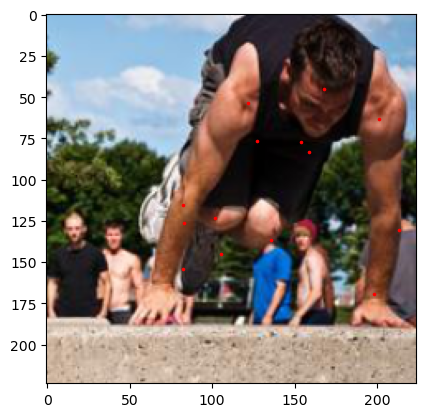

In [69]:
test = next(iter(test_loader))
test_images = test['image']
test_kps = test['landmarks']
print(test['image'].shape, test_kps.shape)
index = np.random.randint(0,64)
img = test_images[index].numpy().transpose(1,2,0)
kp = test_kps[index]*224
show_landmarks(img, kp.reshape(-1, 2))